# Testando um framework de Deep Learning

Usando o TensorFlow 2.x no banco de dados Fashion MNIST

## Bibliotecas utilizados

In [1]:
# bibliotecas
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
# melhroar a visualização 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Carregar dados

O método `load_data()` retorna duas tuplas para treino e teste

In [2]:
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = keras.datasets.fashion_mnist.load_data()

## Exploração dos dados

### Dimensões dos datasets

In [3]:
print(f'X treino: {X_train_orig.shape}')
print(f'y treino: {y_train_orig.shape}')
print(f'X teste: {X_test_orig.shape}')
print(f'y teste: {y_test_orig.shape}')

X treino: (60000, 28, 28)
y treino: (60000,)
X teste: (10000, 28, 28)
y teste: (10000,)


## Número de classes e Balanceamento das classes

In [4]:
print(f'y treino\n{np.unique(y_train_orig, return_counts=True)}\n')
print(f'y teste\n{np.unique(y_test_orig, return_counts=True)}')

y treino
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

y teste
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


## Pré-processamento dos dados

### Normalizar os pixels

A intensidade dos pixels tem um valor máximo de 255. A normalização irá concatena-lo em um intervalo [0,1].

In [5]:
# funcao que normaliza os dados e transforma em float32
norm_float = lambda x: (x / 255.0).astype('float32')

In [6]:
# aplica a funcao nos dados
X_train = norm_float(X_train_orig)
X_test = norm_float(X_test_orig)

### Redimensionar as features

O TensorFlow espera um array de itens com 3 dimensões (no caso de imangens):
* Dimensão 0: Número de itens
* Dimensão 1: Número de linhas
* Dimensão 2: Número de colunas
* Dimensão 3: Número de camadas (rgb=3, cinza=1)

Entretanto os dados disponíveis tem 3 dimensões (60000/10000 itens, 28 linhas de pixel, 28 colunas de pixel).

In [7]:
# dimensoes dos dados
print('Dimensões dos dados de treino')
print(X_train.shape)
print(f'Itens: {X_train.shape[0]}')
print(f'Pixel linha: {X_train.shape[1]}')
print(f'Pixel coluna: {X_train.shape[2]}')

print('\nDimensões dos dados de teste')
print(X_test.shape)
print(f'Itens: {X_test.shape[0]}')
print(f'Pixel linha: {X_test.shape[1]}')
print(f'Pixel coluna: {X_test.shape[2]}')

Dimensões dos dados de treino
(60000, 28, 28)
Itens: 60000
Pixel linha: 28
Pixel coluna: 28

Dimensões dos dados de teste
(10000, 28, 28)
Itens: 10000
Pixel linha: 28
Pixel coluna: 28


In [8]:
# redimensionar imagens
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [9]:
# dimensoes dos dados redimensionados
print('Dimensões dos dados de treino')
print(X_train.shape)

print('\nDimensões dos dados de teste')
print(X_test.shape)

Dimensões dos dados de treino
(60000, 28, 28, 1)

Dimensões dos dados de teste
(10000, 28, 28, 1)


### Dimesão dos dados de saída (target)

A variável target é um valor inteiro que varia de 0 a 9. Esses valores são variáveis categóricas nominais e não tem hierarquia em relação ao seu valor. Para resolver esse problema, deve-se aplicar a técnica de _one hot encoding_ e então a saída será um array de 0s e 1s para cada valor.

In [10]:
 # one hot encoding para a variável target
 y_train = keras.utils.to_categorical(y_train_orig)
 y_test = keras.utils.to_categorical(y_test_orig)

In [11]:
# visualizar a mudança
print('Variável target de treino:')
print('Var\tAntigo\tNovo')
for i in range(6):
  print(f'{i}\t{y_train_orig[i]}\t{y_train[i]}')

print('\nVariável target de teste:')
print('Var\tAntigo\tNovo')
for i in range(6):
  print(f'{i}\t{y_test_orig[i]}\t{y_test[i]}')

Variável target de treino:
Var	Antigo	Novo
0	9	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
1	0	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2	0	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3	3	[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
4	0	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5	2	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

Variável target de teste:
Var	Antigo	Novo
0	9	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
1	2	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
2	1	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
3	1	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4	6	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
5	1	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Definindo uma Rede Neural Convolucional (CNN)

Framework __VGGNet__ retirado do blog do [Adrian Rosebroke](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/)

In [12]:
# first CONV => RELU => CONV => RELU => POOL layer set
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding="same", activation='relu',))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set
model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(keras.layers.BatchNormalization(axis=1))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

# softmax classifier
model.add(keras.layers.Dense(10, activation='softmax'))

### Compilar o modelo

Hiperparêmtros para o modelo:
* `optmizer`: método de otimização (sgd, adam...)
* `loss`: Função de perda (log_loss, crossentropy...)
* `metrics`: métrica de avaliação (accuracy, recall, precision...)

In [13]:
%%time

# compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ajustar o modelo e salvar o histórico (usando GPU do Google Colab)
history = model.fit(X_train, y_train, epochs=10, validation_split=0.25)

Epoch 1/10
1407/1407 [==============================] - 18s 13ms/step - loss: 0.5030 - accuracy: 0.8248 - val_loss: 0.3812 - val_accuracy: 0.8674
Epoch 2/10
1407/1407 [==============================] - 18s 13ms/step - loss: 0.3327 - accuracy: 0.8816 - val_loss: 0.2644 - val_accuracy: 0.9033
Epoch 3/10
1407/1407 [==============================] - 18s 13ms/step - loss: 0.2830 - accuracy: 0.8987 - val_loss: 0.3528 - val_accuracy: 0.8701
Epoch 4/10
1407/1407 [==============================] - 18s 13ms/step - loss: 0.2747 - accuracy: 0.9014 - val_loss: 0.2256 - val_accuracy: 0.9175
Epoch 5/10
1407/1407 [==============================] - 18s 13ms/step - loss: 0.2468 - accuracy: 0.9112 - val_loss: 0.2000 - val_accuracy: 0.9247
Epoch 6/10
1407/1407 [==============================] - 18s 13ms/step - loss: 0.2234 - accuracy: 0.9198 - val_loss: 0.2181 - val_accuracy: 0.9202
Epoch 7/10
1407/1407 [==============================] - 18s 13ms/step - loss: 0.2207 - accuracy: 0.9215 - val_loss: 0.2034 -

### Avaliando o modelo


In [14]:
y_hat = model.predict(X_test)
y_hat_classes = np.argmax(y_hat, axis=1)

print(classification_report(y_test_orig, y_hat_classes))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.92      0.88      0.90      1000
           3       0.89      0.96      0.92      1000
           4       0.84      0.92      0.88      1000
           5       0.99      0.98      0.99      1000
           6       0.87      0.67      0.76      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



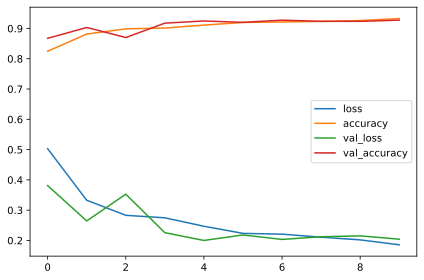

In [15]:
pd.DataFrame(history.history).plot()
plt.tight_layout()

## Conclusão

Resultado muito interessante com métricas excelentes!
* Precision geral = 93%
* Recall geral = 92%
* F1 score geral = 92%
